In [2]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import h5py

# Data structures

In [18]:
class JetNetFeatures:
    
    def __init__(self, events, masked=True, max_num_consts=150): 
        
        self.num_jets, num_consts, dim = events.shape
        self.max_num_consts = max_num_consts

        # fill with zero padding up to 'max_num_consts' if necessary

        if num_consts < max_num_consts:
            zero_rows = torch.zeros(self.num_jets, 150 - num_consts, dim)
            events = torch.cat((events, zero_rows), dim=1) 

        # get particle features

        eta_rel = events[..., 0, None]
        phi_rel = events[..., 1, None]
        pt_rel = events[..., 2, None] 
        mask = events[..., 3, None] if masked else (events[..., 0] + events[..., 1] + events[..., 2] != 0).int().unsqueeze(-1) 
        R = torch.sqrt(eta_rel**2 + phi_rel**2)

        data = torch.cat((eta_rel, phi_rel, pt_rel, R, mask), dim=-1)    
        _ , i = torch.sort(data[:, :, 2], dim=1, descending=True) # pt sort
        self.particles = torch.gather(data, 1, i.unsqueeze(-1).expand_as(data)) 
    
    
    #...default features

    @property 
    def features(self): 
        return self.particles[..., :4] 
    @property 
    def eta_rel(self): 
        return self.particles[..., 0] 
    @property 
    def phi_rel(self): 
        return self.particles[..., 1]
    @property 
    def pt_rel(self): 
        return self.particles[..., 2]
    @property 
    def R(self): 
        return self.particles[..., 3]
    @property 
    def mask(self): 
        return self.particles[..., -1] 
    @property 
    def multiplicity(self):
        return self.particles[..., -1].sum(dim=-1)
    
    def get_jet_features(self):
        
        pt = self.particles[..., 2, None]
        eta = self.particles[..., 0, None]
        phi = self.particles[..., 1, None]
        mask = self.particles[..., -1, None]
        
        multiplicity =  torch.sum(mask, dim=1)
        e_j  = torch.sum(mask * pt * torch.cosh(eta), dim=1)
        px_j = torch.sum(mask * pt * torch.cos(phi), dim=1)
        py_j = torch.sum(mask * pt * torch.sin(phi), dim=1)
        pz_j = torch.sum(mask * pt * torch.sinh(eta), dim=1)
        
        pt_j = torch.sqrt(px_j**2 + py_j**2)
        m_j  = torch.sqrt(e_j**2 - px_j**2 - py_j**2 - pz_j**2)
        eta_j = torch.arcsinh(pz_j / pt_j)
        phi_j = torch.arctan2(py_j, px_j)
        
        self.jets = torch.cat((pt_j, eta_j, phi_j, m_j, e_j, pz_j, multiplicity), dim=-1) 
    
    def get_mean_std(self):
        self.mean = torch.mean(self.particles, dim=-1)
        self.std = torch.std(self.particles, dim=-1)

    def nth_particle(self, n, feature=None):
        particles = self.particles[..., n-1, :]
        mask = particles[..., -1] > 0
        if feature is None:
            return particles[mask][..., :-1]
        else:
            idx = {'eta_rel':0, 'phi_rel':1, 'pt_rel':2, 'R':3}
            return particles[mask][..., idx[feature]]
    
    #...data distortions

    def pt_smear(self, scale=0.001):
        mask = self.particles[..., -1] 
        energy_resolution = np.sqrt( (0.00025 * self.particles[..., 2])**2 + 0.015**2) 
        noise = scale * energy_resolution * torch.randn_like(self.particles[..., 2])
        self.particles[..., 2] = self.particles[..., 2] - mask * torch.abs(noise)
  
    def coordinate_shift(self, loc_eta=0.01, loc_phi=0.0):
        mask = self.particles[..., -1] 
        eta_noise = loc_eta * torch.randn_like(self.particles[..., 0])
        phi_noise = loc_phi * torch.randn_like(self.particles[..., 1])
        self.particles[..., 0] = self.particles[..., 0] + mask * eta_noise
        self.particles[..., 1] = self.particles[..., 1] + mask * phi_noise
    
    #...data processing

    def standardize(self, inverse=False, sigma=1):
        mask = self.particles[..., -1, None] > 0
        if not inverse: 
            self.mean = torch.mean(self.particles[mask], dim=-1)
            self.std = torch.std(self.particles[mask], dim=-1)
            self.particles[..., :4][mask] = (self.features[mask] - self.mean) * (sigma / self.std )
            print('INFO: standardizing data to zero-mean and std={}'.format(sigma)) 
        else:
            self.particles[..., :4][mask] = self.features[mask] * (self.std / sigma) +  self.mean
            print('INFO: un-standardizing data')

    def normalize(self, inverse=False):
        mask = self.particles[..., -1, None] > 0
        if not inverse:
            self.max, _ = torch.max(self.features[mask], dim=0)
            self.min, _ = torch.min(self.features[mask], dim=0)
            self.particles[..., :4][mask] = (self.features[mask] - self.min) / (self.max - self.min) 
            print('INFO: normalizing data')
        else:
            self.particles[..., :4][mask] = self.features[mask] * (self.max - self.min) + self.min 
            print('INFO: un-normalizing data')

    def logit_transform(self, alpha=1e-6, inverse=False):
        mask = self.particles[..., -1, None] > 0
        if not inverse:
            self.particles[..., :4][mask] = logit(self.features[mask], alpha=alpha)
            print('INFO: applying logit transform alph={}'.format(alpha))
        else:
            self.particles[..., :4][mask] = expit(self.features[mask], alpha=alpha)
            print('INFO: applying expit transform alph={}'.format(alpha))

    def preprocess(self, alpha=1e-6):
        self.normalize()
        self.logit_transform(alpha=alpha)
        self.standardize()

    def postprocess(self, alpha=1e-6):
        self.standardize(inverse=True)
        self.logit_transform(alpha=alpha, inverse=True)
        self.normalize(inverse=True)
        
    #...plot methods
    
    def particle_plot(self, 
                      feature, 
                      nth_particle=None, 
                      masked=True, 
                      bins=100, 
                      color='k',
                      xlog=False,
                      ylog=True, 
                      fill=True, 
                      ax=None,  
                      figsize=(3,3)): 
        
        idx = {'eta_rel':0, 'phi_rel':1, 'pt_rel':2, 'R':3}        
        if nth_particle is None:
            x = self.particles[..., idx[feature]] 
            mask = self.particles[..., -1] > 0
            x = x[mask].flatten() if masked else x.flatten() 
        else:
            x = self.nth_particle(n=nth_particle, feature=feature)
        
        fig, ax = plt.subplots(1, figsize=figsize) if ax is None else (None, ax)
        lw, alpha = (0.0, 0.2) if fill else (0.75, 1.0)
        sns.histplot(x=x, color=color, bins=bins, element="step", log_scale=(xlog, ylog), lw=lw, fill=fill, alpha=alpha, ax=ax) 
        plt.xlabel(r'{}'.format(feature))

    def jet_plot(self, 
                 feature, 
                 color='k', 
                 bins=100, 
                 xlog=False,
                 ylog=True,                
                 fill=True,
                 ax=None,
                 figsize=(3,3)):
        
        idx = {'pt_rel':0, 'eta_rel':1, 'phi_rel':2, 'm_rel':3, 'e_rel':4, 'pz_rel':5, 'multiplicity':6}
        x = self.jets[..., idx[feature]]
        
        fig, ax = plt.subplots(1, figsize=figsize) if ax is None else (_, ax)
        lw, alpha = (0.0, 0.2) if fill else (1.0, 1.0)
        sns.histplot(x=x, color=color, bins=bins, element="step", log_scale=(xlog, ylog), lw=lw, fill=fill, alpha=alpha, ax=ax) 
        plt.xlabel(r'{}'.format(feature))
        
        
    def image(self, event_num=None, figsize=(5,5), legend='brief', bins=(150,150)): 
        sns.set(style="ticks")  # Set the style and font    
        if event_num is not None: data = self.particles[event_num]
        else: data = self.particles
        
        mask = data[..., -1] > 0
        event = data[mask]
        event = torch.flip(event, dims=[0]) # invert pt ordering for plotting
        eta, phi, pt = event[...,0], event[...,1], event[...,2]
        fig, ax = plt.subplots(1, figsize=figsize)
        
        if event_num is not None:
            plt.title('event #{}'.format(event_num))
            sns.scatterplot(x=eta, y=phi, hue=pt, size=pt, palette='viridis', sizes=(10, 50), legend=legend) 
        else:
            plt.title('average events')
            sns.histplot(x=eta, y=phi, bins=bins, cmap='viridis')
            plt.xlim(-1,1)
            plt.ylim(-1,1)
        
        ax.grid(True, color='gray', linestyle='--', linewidth=0.5)
        plt.xlabel(r'$\Delta\eta$')
        plt.ylabel(r'$\Delta\phi$')
    
    
def Bins(xmin, xmax, bins=100):
    dx = (xmax - xmin) / bins
    return np.arange(xmin, xmax, dx)

# Data sets

In [3]:
num_jets = 170000

#...Load JetNet reference data

data = h5py.File('data/t150.hdf5')
data = torch.tensor(data['particle_features'][:num_jets])

#...Load generated data from Flow-Matching 

data_FM = np.load('data/generated_data_FM.npy')
data_FM = torch.Tensor(data_FM[:num_jets])


#...Load generated data from Diffusion (Jedi)

data_DIFF = h5py.File('data/ddim_200.h5')
data_DIFF = torch.tensor(data_DIFF['etaphipt_frac'][:num_jets])


In [6]:
#...get features

JetNet = JetNetFeatures(data, masked=True, max_num_consts=150)
JetNet.get_jet_features()

JetNet_FM = JetNetFeatures(data_FM, masked=False, max_num_consts=150)
JetNet_FM.get_jet_features()

JetNet_DIFF = JetNetFeatures(data_DIFF, masked=False, max_num_consts=150)
JetNet_DIFF.get_jet_features()

# Jet images

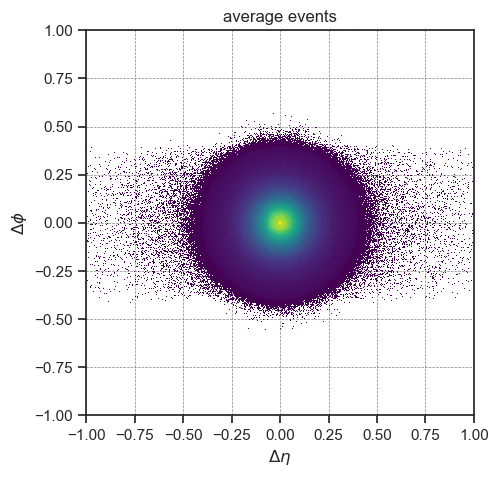

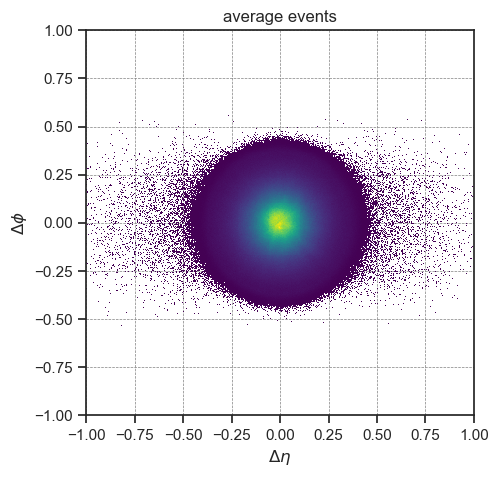

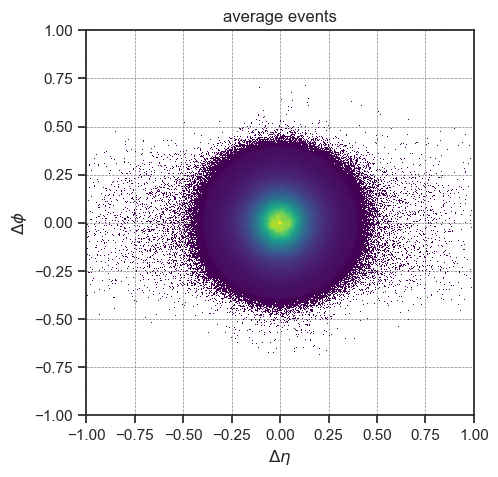

In [7]:
bins = (np.arange(-1,1,0.005),np.arange(-1,1,0.005))

JetNet.image(bins=bins) 
JetNet_FM.image(bins=bins)
JetNet_DIFF.image(bins=bins)

# Particle-level distributions

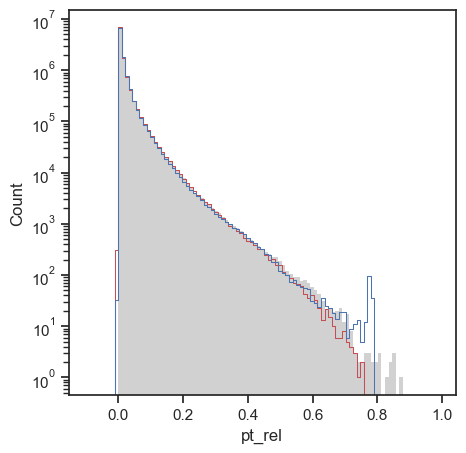

In [8]:
fig, ax = plt.subplots(1, figsize=(5,5))
JetNet.particle_plot(feature='pt_rel', bins=Bins(-0.1,1), ax=ax) 
JetNet_FM.particle_plot(feature='pt_rel', bins=Bins(-0.1,1),  fill=False, color='r', ax=ax) 
JetNet_DIFF.particle_plot(feature='pt_rel', bins=Bins(-0.1,1), fill=False, color='b', ax=ax) 

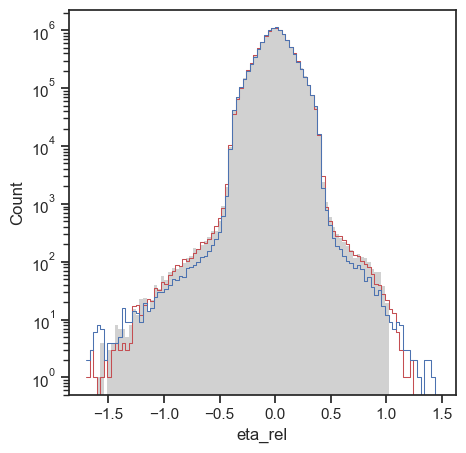

In [9]:
fig, ax = plt.subplots(1, figsize=(5,5))
JetNet.particle_plot(feature='eta_rel', bins=Bins(-1.7,1.5), ax=ax) 
JetNet_FM.particle_plot(feature='eta_rel', bins=Bins(-1.7,1.5),  fill=False, color='r', ax=ax) 
JetNet_DIFF.particle_plot(feature='eta_rel', bins=Bins(-1.7,1.5), fill=False, color='b', ax=ax) 

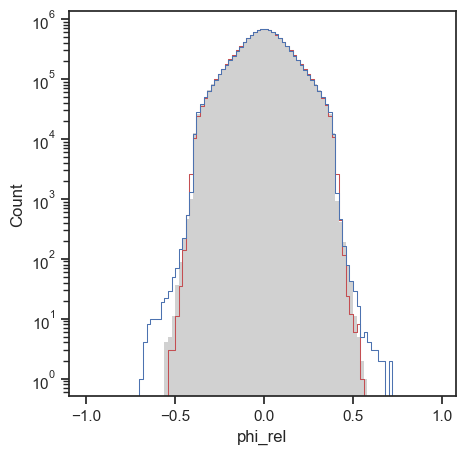

In [10]:
fig, ax = plt.subplots(1, figsize=(5,5))
JetNet.particle_plot(feature='phi_rel', bins=Bins(-1,1), ax=ax) 
JetNet_FM.particle_plot(feature='phi_rel', bins=Bins(-1,1),  fill=False, color='r', ax=ax) 
JetNet_DIFF.particle_plot(feature='phi_rel', bins=Bins(-1,1), fill=False, color='b', ax=ax) 

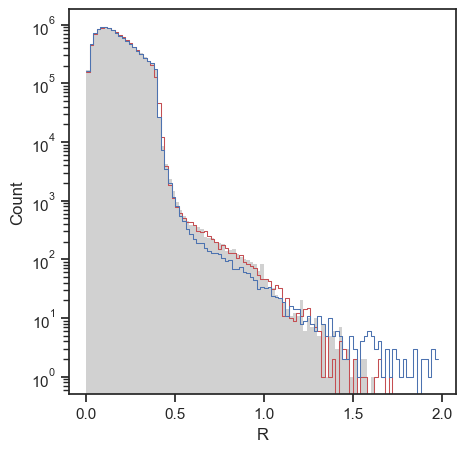

In [11]:
fig, ax = plt.subplots(1, figsize=(5,5))
JetNet.particle_plot(feature='R', bins=Bins(0,2), ax=ax) 
JetNet_FM.particle_plot(feature='R', bins=Bins(0,2),  fill=False, color='r', ax=ax) 
JetNet_DIFF.particle_plot(feature='R', bins=Bins(0,2), fill=False, color='b', ax=ax) 

# Distributions for the n^th hardest particles

Text(0.5, 1.0, 'hardest particles in jet')

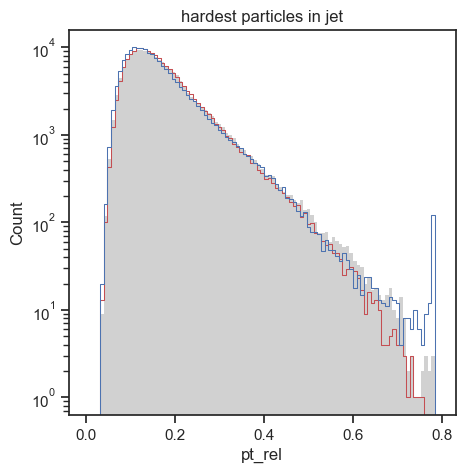

In [57]:
fig, ax = plt.subplots(1, figsize=(5,5))
JetNet.particle_plot(feature='pt_rel', nth_particle=1, bins=Bins(0,0.8), ax=ax) 
JetNet_FM.particle_plot(feature='pt_rel', nth_particle=1, bins=Bins(0,0.8), fill=False, color='r', ax=ax) 
JetNet_DIFF.particle_plot(feature='pt_rel', nth_particle=1, bins=Bins(0,0.8), fill=False, color='b', ax=ax) 
plt.title(r'hardest particles in jet')

Text(0.5, 1.0, 'hardest particles in jet')

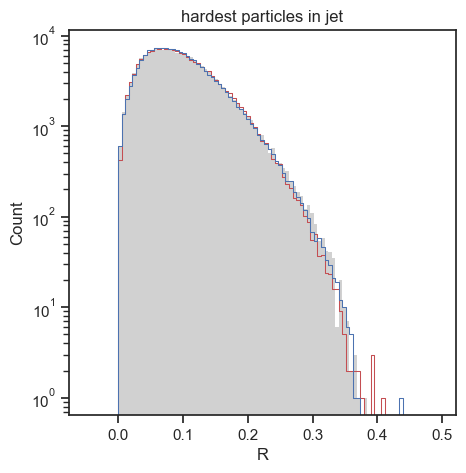

In [58]:
fig, ax = plt.subplots(1, figsize=(5,5))
JetNet.particle_plot(feature='R', nth_particle=1, bins=Bins(-0.05,0.5), ax=ax) 
JetNet_FM.particle_plot(feature='R', nth_particle=1, bins=Bins(-0.05,0.5), fill=False, color='r', ax=ax) 
JetNet_DIFF.particle_plot(feature='R', nth_particle=1, bins=Bins(-0.05,0.5), fill=False, color='b', ax=ax) 
plt.title(r'hardest particles in jet')

Text(0.5, 1.0, '30$^{th}$ hardest particles in jet')

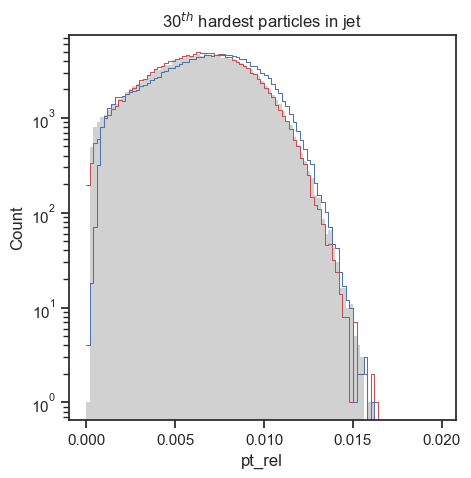

In [59]:
fig, ax = plt.subplots(1, figsize=(5,5))
JetNet.particle_plot(feature='pt_rel', nth_particle=30, bins=Bins(0,0.02), ax=ax) 
JetNet_FM.particle_plot(feature='pt_rel', nth_particle=30, bins=Bins(0,0.02), fill=False, color='r', ax=ax) 
JetNet_DIFF.particle_plot(feature='pt_rel', nth_particle=30, bins=Bins(0,0.02), fill=False, color='b', ax=ax) 
plt.title(r'30$^{th}$ hardest particles in jet')

Text(0.5, 1.0, '30$^{th}$ hardest particles in jet')

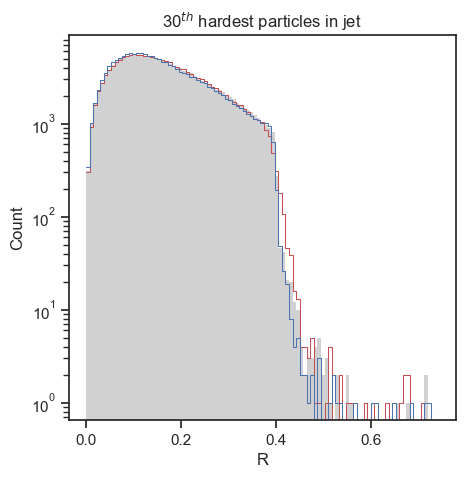

In [60]:
fig, ax = plt.subplots(1, figsize=(5,5))
JetNet.particle_plot(feature='R', nth_particle=30, bins=Bins(0,0.75), ax=ax) 
JetNet_FM.particle_plot(feature='R', nth_particle=30, bins=Bins(0,0.75), fill=False, color='r', ax=ax) 
JetNet_DIFF.particle_plot(feature='R', nth_particle=30, bins=Bins(0,0.75), fill=False, color='b', ax=ax) 
plt.title(r'30$^{th}$ hardest particles in jet')

# Jet-level distributions

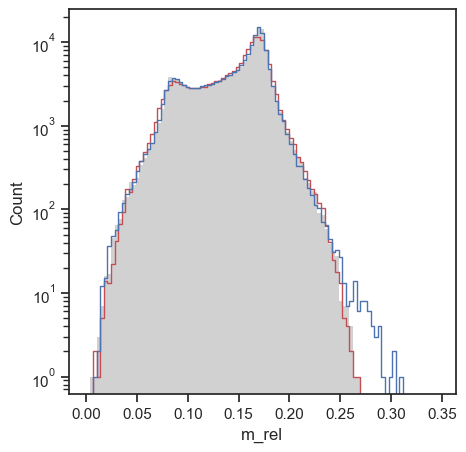

In [74]:
fig, ax = plt.subplots(1, figsize=(5,5))
JetNet.jet_plot(feature='m_rel', bins=Bins(0,0.35), ax=ax) 
JetNet_FM.jet_plot(feature='m_rel', bins=Bins(0,0.35),  fill=False, color='r', ax=ax) 
JetNet_DIFF.jet_plot(feature='m_rel', bins=Bins(0,0.35), fill=False, color='b', ax=ax) 

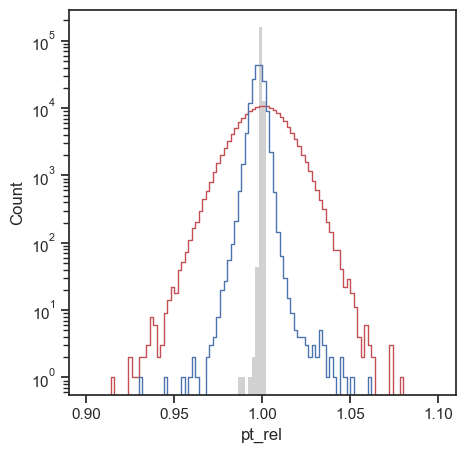

In [61]:
fig, ax = plt.subplots(1, figsize=(5,5))
JetNet.jet_plot(feature='pt_rel', bins=Bins(0.9,1.1), ax=ax) 
JetNet_FM.jet_plot(feature='pt_rel', bins=Bins(0.9,1.1),  fill=False, color='r', ax=ax) 
JetNet_DIFF.jet_plot(feature='pt_rel', bins=Bins(0.9,1.1), fill=False, color='b', ax=ax) 

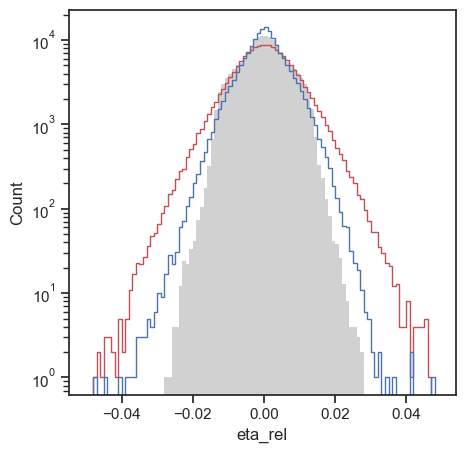

In [72]:
fig, ax = plt.subplots(1, figsize=(5,5))
JetNet.jet_plot(feature='eta_rel', bins=Bins(-0.05,0.05), ax=ax) 
JetNet_FM.jet_plot(feature='eta_rel', bins=Bins(-0.05,0.05),  fill=False, color='r', ax=ax) 
JetNet_DIFF.jet_plot(feature='eta_rel', bins=Bins(-0.05,0.05), fill=False, color='b', ax=ax)

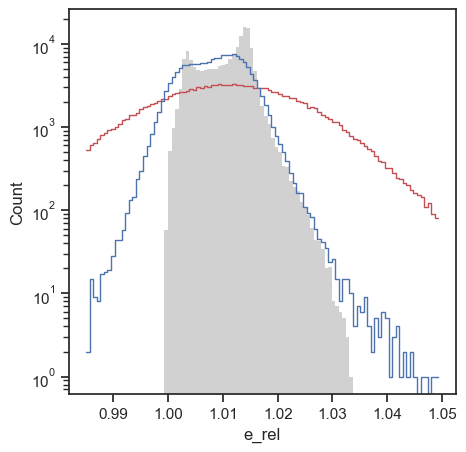

In [68]:
fig, ax = plt.subplots(1, figsize=(5,5))
JetNet.jet_plot(feature='e_rel', bins=Bins(0.985,1.05), ax=ax) 
JetNet_FM.jet_plot(feature='e_rel', bins=Bins(0.985,1.05),  fill=False, color='r', ax=ax) 
JetNet_DIFF.jet_plot(feature='e_rel', bins=Bins(0.985,1.05), fill=False, color='b', ax=ax) 